In [1]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.utils
import PIL
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision import datasets
import d2l
from d2l import torch as d2l
from IPython import display
import datetime
import torch.nn.functional as F

In [2]:
#Downloading CIFAR-10
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) #下载太慢请开代理

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 引入normalize的数据初始化
tensor_cifar10_normalize_train = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

tensor_cifar10_normalize_val = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

In [4]:
# Build the dataset and DataLoader

label_map = {0: 0, 2: 1} # 占位符
class_names = ['airplane', 'bird']
# 训练集
cifar2 = [(img, label_map[label])
    for img, label in tensor_cifar10_normalize_train
        if label in [0, 2]]
# 验证集
#cifar2_val = [(img, label_map[label])
#   for img, label in tensor_cifar10_normalize_val
#      if label in [0, 2]]

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [5]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4.5, 3.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [6]:
# train_loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    
    animator = Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0.0, 0.6], legend=['train loss'])
    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        animator.add(epoch, loss_train / len(train_loader))

        #if epoch == 1 or epoch % 10 == 0:
         #   print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [7]:
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

model.cuda()

optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.NLLLoss()
n_epochs = 100

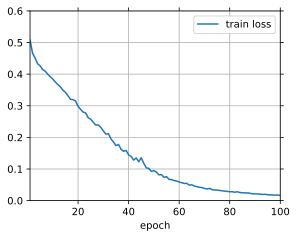

In [8]:
training_loop(
            n_epochs = n_epochs,
            optimizer = optimizer,
            model = model,
            loss_fn = loss_fn,
            train_loader = train_loader,
            )